# Comparison of optimization algorithms on QFTs

This notebook shows the different results of the optimization algorithms listed in the thesis,
applied to Quantum Fourier Transform circuits of different sizes.

First, we import the necessary modules, which in this case is mainly just `pyzx`.

In [1]:
import sys
import threading
import math
import pyzx as zx

If you want to run this notebook yourself, consider lowering `max_qft_n`, as it otherwise may take a very long time to compute all the large circuits.

In [2]:
max_qft_n = 50

The following function generates the OpenQASM 2.0 code for any size of QFT.

In [3]:
def qft(qft_n):
    qasm = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[""" + str(qft_n) + """];
"""
    for i in range(qft_n):
        qasm += "h q[" + str(i) + "];\n"
        for j in range(1,qft_n-i):
            #qasm += "ctrl @ rz(pi/" + str(2**j) + ") q[" + str(i+j) + "], q[" + str(i) + "];\n"
            qasm += "rz(pi/" + str(2**(j+1)) + ") q[" + str(i+j) + "];\n"
            qasm += "CX q[" + str(i+j) + "], q[" + str(i) + "];\n"
            qasm += "rz(-pi/" + str(2**(j+1)) + ") q[" + str(i) + "];\n"
            qasm += "CX q[" + str(i+j) + "], q[" + str(i) + "];\n"
            qasm += "rz(pi/" + str(2**(j+1)) + ") q[" + str(i) + "];\n"
    for i in range(math.floor(qft_n/2)):
        qasm += "CX q[" + str(i) + "], q[" + str(qft_n - 1 - i) + "];\n"
        qasm += "CX q[" + str(qft_n - 1 - i) + "], q[" + str(i) + "];\n"
        qasm += "CX q[" + str(i) + "], q[" + str(qft_n - 1 - i) + "];\n"
    return qasm

The following code then performs the various optimization algorithms.

In [4]:
qft_circuits = []
t_count_before = []
t_count_optimized = []
t_count_simplified = []
t_count_after = []
t_count_iter = []
t_count_full = []
t_count_full_optimized = []
two_count_before = []
two_count_optimized = []
two_count_simplified = []
two_count_after = []
two_count_iter = []
two_count_full = []
two_count_full_optimized = []
gate_count_before = []
gate_count_optimized = []
gate_count_simplified = []
gate_count_after = []
gate_count_iter = []
gate_count_full = []
gate_count_full_optimized = []
for n in range(2,max_qft_n+1):
    qasm = qft(n)
    c = zx.Circuit.from_qasm(qasm)
    t_count_before.append(c.tcount())
    two_count_before.append(c.twoqubitcount())
    gate_count_before.append(len(c.gates))
    qft_circuits.append(c)
print("Circuits generated, starting optimization algorithms...")

def optimize():
    for n in range(2,max_qft_n+1):
        c = qft_circuits[n-2]
        c_o = zx.optimize.basic_optimization(c.copy().to_basic_gates())
        t_count_optimized.append(c_o.tcount())
        two_count_optimized.append(c_o.twoqubitcount())
        gate_count_optimized.append(len(c_o.gates))
    print("Basic optimization finished.")

def interior_clifford_simplification():
    for n in range(2,max_qft_n+1):
        c = qft_circuits[n-2]
        # Interior Clifford simplification & optimization
        g_i = c.copy().to_basic_gates().to_graph()
        zx.simplify.interior_clifford_simp(g_i, quiet=True)
        c_i = zx.extract_circuit(g_i.copy())
        c_j = zx.optimize.basic_optimization(c_i.copy().to_basic_gates())
        t_count_iter.append(c_j.tcount())
        two_count_iter.append(c_j.twoqubitcount())
        gate_count_iter.append(len(c_j.gates))
    print("Interior Clifford simplification finished.")

def clifford_simplification():
    for n in range(2,max_qft_n+1):
        c = qft_circuits[n-2]
        # Clifford simplification
        g = c.copy().to_basic_gates().to_graph()
        zx.clifford_simp(g, quiet=True)
        g.normalize()
        c_s = zx.extract_circuit(g.copy())
        t_count_simplified.append(c_s.tcount())
        two_count_simplified.append(c_s.twoqubitcount())
        gate_count_simplified.append(len(c_s.gates))
        # Optimization after Clifford simplification
        c_a = zx.optimize.basic_optimization(c_s.copy().to_basic_gates())
        t_count_after.append(c_a.tcount())
        two_count_after.append(c_a.twoqubitcount())
        gate_count_after.append(len(c_a.gates))
    print("Clifford simplification finished.")
        
def full_simplification():
    for n in range(2,max_qft_n+1):
        c = qft_circuits[n-2]
        # Full simplification
        g_f = c.copy().to_basic_gates().to_graph()
        zx.full_reduce(g_f, quiet=True)
        g_f.normalize()
        c_f = zx.extract_circuit(g_f.copy())
        t_count_full.append(c_f.tcount())
        two_count_full.append(c_f.twoqubitcount())
        gate_count_full.append(len(c_f.gates))
        # Optimization after full simplification
        c_fo = zx.optimize.basic_optimization(c_f.copy().to_basic_gates())
        t_count_full_optimized.append(c_fo.tcount())
        two_count_full_optimized.append(c_fo.twoqubitcount())
        gate_count_full_optimized.append(len(c_fo.gates))
    print("Full simplification finished.")

t1 = threading.Thread(target=optimize)
t2 = threading.Thread(target=interior_clifford_simplification)
t3 = threading.Thread(target=clifford_simplification)
t1.start()
t2.start()
t3.start()
full_simplification()
t1.join()
t2.join()
t3.join()

Circuits generated, starting optimization algorithms...
Basic optimization finished.
Interior Clifford simplification finished.
Clifford simplification finished.
Full simplification finished.


Now, let us print the results.

`Before` denotes the gate counts of the QFT circuit before any optimization.
`Optimized` means that just the basic optimization of canceling gates is performed.
`InteriorSimp` is the algorithm from Theorem 6.0.1.
`Simplified` is the Clifford simplification algorithm from Theorem 6.0.6.
`FullSimp` is the full simplification algorithm from Theorem 6.0.7.

In [5]:
print("".ljust(12), "Before", "Optimized", "InteriorSimp&Optimized", "Simplified", "Simplified&Optimized", "FullSimp", "FullSimp&Optimized")
for n in range(2,len(t_count_before)+2):
    i = n - 2
    print("QFT" + str(n))
    print("  T-count".ljust(12), str(t_count_before[i]).rjust(6), str(t_count_optimized[i]).rjust(9), str(t_count_iter[i]).rjust(22), str(t_count_simplified[i]).rjust(10), str(t_count_after[i]).rjust(20), str(t_count_full[i]).rjust(8), str(t_count_full_optimized[i]).rjust(18))
    print("  2q-count".ljust(12), str(two_count_before[i]).rjust(6), str(two_count_optimized[i]).rjust(9), str(two_count_iter[i]).rjust(22), str(two_count_simplified[i]).rjust(10), str(two_count_after[i]).rjust(20), str(two_count_full[i]).rjust(8), str(two_count_full_optimized[i]).rjust(18))
    print("  gate count".ljust(12), str(gate_count_before[i]).rjust(6), str(gate_count_optimized[i]).rjust(9), str(gate_count_iter[i]).rjust(22), str(gate_count_simplified[i]).rjust(10), str(gate_count_after[i]).rjust(20), str(gate_count_full[i]).rjust(8), str(gate_count_full_optimized[i]).rjust(18))

             Before Optimized InteriorSimp&Optimized Simplified Simplified&Optimized FullSimp FullSimp&Optimized
QFT2
  T-count         3         3                      3          3                    3        3                  3
  2q-count        5         5                      5          3                    3        5                  5
  gate count     10        10                     10         14                   14       14                 10
QFT3
  T-count         9         8                      8          8                    7        7                  7
  2q-count        9         9                      9         13                   11       12                 10
  gate count     21        20                     20         38                   21       32                 21
QFT4
  T-count        18        15                     15         14                   13       12                 12
  2q-count       18        18                     18         22                  

Visualization of the results:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
colors = [
    '#003f5c',
    '#444e86',
    '#955196',
    '#dd5182',
    '#ff6e54',
    '#ffa600'
]
names = [
    "Original",
    "Optimized/Interior simplification & optimized",
    "Clifford simplification",
    "Clifford simplification & optimized",
    "Full simplification",
    "Full simplification & optimized"
]
styles = ['-','--','-.',':','--','-.']
xs = range(2,max_qft_n+1)

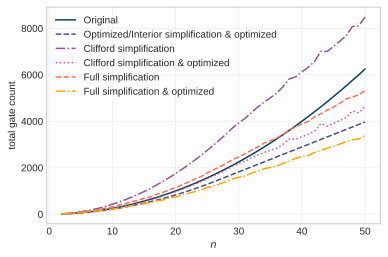

In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
yys = [
    gate_count_before,
    gate_count_iter,
    gate_count_simplified,
    gate_count_after,
    gate_count_full,
    gate_count_full_optimized
]
for i, ys in enumerate(yys):
    ax1.plot(xs, ys, c=colors[i], linestyle=styles[i], label=names[i])

ax1.set_ylabel("total gate count")
ax1.set_xlabel("$n$")
plt.legend(loc='upper left');
plt.grid(color='#EEEEEE')
plt.show()

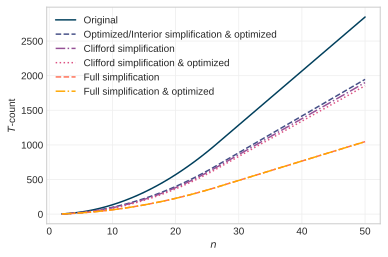

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
yys = [
    t_count_before,
    t_count_iter,
    t_count_simplified,
    t_count_after,
    t_count_full,
    t_count_full_optimized
]
for i, ys in enumerate(yys):
    ax1.plot(xs, ys, c=colors[i], linestyle=styles[i], label=names[i])

ax1.set_ylabel("$T$-count")
ax1.set_xlabel("$n$")
plt.legend(loc='upper left');
plt.grid(color='#EEEEEE')
plt.show()

We can draw the following conclusions from these results:

- Interior Clifford simplification (followed by basic optimization) has essentially no effect on QFT circuits, at least in the QFTs up to 50 qubits that were tested here. The results are always exactly the same as just applying basic optimization by itself.
- Clifford simplification (followed by basic optimization) achieves a minor improvement of _T_-count and a significant improvement of total gate count.
- Full simplification (followed by basic optimization) achieves a significant reduction of _T_-count and a good improvement of total gate count. Though the total gate count is often not as good as after Clifford simplification, leading to cases like QFT5 being worse after full simplification than after Clifford simplification.